In [1]:
# Lightweight helpers and redefinitions to reduce memory without changing outputs
import os
import pandas as pd
import numpy as np
from functools import reduce
from operator import mul


def iter_param_combinations(indicator_name: str):
    """Yield parameter combinations lazily to avoid materializing large lists."""
    if indicator_name not in INDICATOR_PARAMS:
        return
    param_names = list(INDICATOR_PARAMS[indicator_name].keys())
    param_values = list(INDICATOR_PARAMS[indicator_name].values())
    from itertools import product
    for combo in product(*param_values):
        yield {param_names[i]: combo[i] for i in range(len(param_names))}


def count_param_combinations(indicator_name: str) -> int:
    """Count combinations without generating them."""
    if indicator_name not in INDICATOR_PARAMS:
        return 0
    lengths = [len(v) for v in INDICATOR_PARAMS[indicator_name].values()]
    return reduce(mul, lengths, 1)


def _ensure_df(results_like):
    """Accept list[dict] or DataFrame and return a DataFrame view."""
    if isinstance(results_like, list):
        return pd.DataFrame(results_like)
    return results_like


def run_comprehensive_grid_search(data: pd.DataFrame, indicator_params: dict,
                                  indicator_class,
                                  max_combinations_per_indicator: int = 0,
                                  stream_results_dir: str | None = None) -> dict:
    """
    Memory-light reimplementation:
    - Iterates parameter combinations lazily
    - Stores results as list[dict] per (ticker, indicator)
    - Avoids building temporary DataFrames inside the inner loop
    - Optional streaming append to CSV per (ticker, indicator)
    """
    all_results: dict[str, dict[str, list[dict]]] = {}
    tickers = pd.Index(data['Ticker']).unique().tolist()

    for ticker in tickers:
        print(f"\n📊 Processing {ticker}...")
        ticker_data = data.loc[data['Ticker'] == ticker].copy()
        ticker_data.sort_index(inplace=True)
        indicator_obj = indicator_class(ticker_data)
        all_results[ticker] = {}

        for indicator_name, _ in indicator_params.items():
            total_combos = count_param_combinations(indicator_name)
            if total_combos == 0:
                continue
            limit = max_combinations_per_indicator or 0
            if limit and limit > 0 and limit < total_combos:
                print(f"    📉 Limiting to first {limit} of {total_combos} {indicator_name} combinations")
            else:
                print(f"    🔁 Evaluating {total_combos} {indicator_name} combinations")

            indicator_results: list[dict] = []
            processed = 0

            for params in iter_param_combinations(indicator_name):
                processed += 1
                if limit and processed > limit:
                    break
                try:
                    # Calculate indicator values based on parameters
                    if indicator_name == 'RSI':
                        indicator_values = indicator_obj.rsi(params['period'])
                    elif indicator_name == 'ADX':
                        indicator_values = indicator_obj.adx(params['period'])
                    elif indicator_name == 'KAMA':
                        indicator_values = indicator_obj.kama(
                            er_period=params['er_period'],
                            fast_period=params['fast_period'],
                            slow_period=params['slow_period']
                        )
                    elif indicator_name == 'ATR':
                        indicator_values = indicator_obj.atr(params['period'])
                    elif indicator_name == 'MFI':
                        indicator_values = indicator_obj.mfi(params['period'])
                    elif indicator_name == 'Supertrend':
                        indicator_values = indicator_obj.supertrend(period=params['period'], multiplier=params['multiplier'])
                    elif indicator_name == 'Entropy':
                        indicator_values = indicator_obj.entropy(params['period'])
                    else:
                        # If unknown indicator, skip
                        continue

                    # Generate signals without building a temporary DataFrame
                    if indicator_name == 'KAMA':
                        _params = dict(params)
                        _params['close'] = ticker_data['Close']
                        signals = get_buy_signal(indicator_name, indicator_values, _params)
                    else:
                        signals = get_buy_signal(indicator_name, indicator_values, params)

                    # Strategy returns using Series-only math
                    daily_return = ticker_data['Close'].pct_change()
                    position = signals.shift(1).fillna(0).astype('float32')
                    strategy_return = (position * daily_return).astype('float32')

                    valid_returns = strategy_return.dropna()
                    if valid_returns.size > 0:
                        total_return = float((1.0 + valid_returns).prod() - 1.0)
                        std = float(valid_returns.std())
                        sharpe = float((valid_returns.mean() / std) * np.sqrt(252)) if std > 0 else 0.0
                        equity = (1.0 + valid_returns).cumprod()
                        max_drawdown = calculate_max_drawdown(equity)
                        win_rate = float((valid_returns > 0).mean())
                    else:
                        total_return = np.nan
                        sharpe = np.nan
                        max_drawdown = np.nan
                        win_rate = np.nan

                    res = {
                        'Indicator': indicator_name,
                        'Parameters': params,
                        'Total_Return': total_return,
                        'Sharpe_Ratio': sharpe,
                        'Max_Drawdown': max_drawdown,
                        'Win_Rate': win_rate,
                        'Total_Signals': int(signals.notna().sum()),
                        'Buy_Signals': int((signals == 1).sum()),
                        'Sell_Signals': int((signals == -1).sum()),
                    }

                    indicator_results.append(res)

                    # Optional streaming append
                    if stream_results_dir is not None:
                        os.makedirs(stream_results_dir, exist_ok=True)
                        ticker_filename = os.path.join(stream_results_dir, f"{ticker}_{indicator_name}.csv")
                        pd.DataFrame([res]).to_csv(
                            ticker_filename,
                            mode='a',
                            header=not os.path.exists(ticker_filename),
                            index=False,
                        )

                except Exception as e:
                    print(f"    ❌ Error with {indicator_name} params {params}: {e}")
                    continue

            # Store results as list (not DataFrame) to save memory
            all_results[ticker][indicator_name] = indicator_results

            # Show best result for this indicator
            if indicator_results:
                try:
                    valid = [r for r in indicator_results if pd.notna(r.get('Sharpe_Ratio'))]
                    if valid:
                        best = max(valid, key=lambda x: x['Sharpe_Ratio'])
                        print(f"    ✅ Best {indicator_name}: Sharpe={best['Sharpe_Ratio']:.3f}, Return={best['Total_Return']:.3f}")
                except Exception:
                    pass

    return all_results


def analyze_grid_search_results(all_results: dict) -> dict:
    """Updated to accept list- or DataFrame-backed results."""
    analysis = {
        'best_per_ticker': {},
        'best_indicators': {},
        'parameter_distances': {},
        'summary_stats': {}
    }

    # Best indicator per ticker
    for ticker, ticker_results in all_results.items():
        best_sharpe = -999.0
        best_indicator = None
        best_params = None

        for indicator_name, results_like in ticker_results.items():
            df = _ensure_df(results_like)
            if df is None or df.empty or 'Sharpe_Ratio' not in df.columns:
                continue
            idx = df['Sharpe_Ratio'].astype(float).idxmax()
            if pd.notna(idx):
                current_sharpe = float(df.loc[idx, 'Sharpe_Ratio'])
                if current_sharpe > best_sharpe:
                    best_sharpe = current_sharpe
                    best_indicator = indicator_name
                    best_params = df.loc[idx, 'Parameters']

        analysis['best_per_ticker'][ticker] = {
            'indicator': best_indicator, 'sharpe': best_sharpe, 'params': best_params
        }

    # Best performing indicators overall
    indicator_perf: dict[str, list[float]] = {}
    for _ticker, ticker_results in all_results.items():
        for indicator_name, results_like in ticker_results.items():
            df = _ensure_df(results_like)
            if df is None or df.empty or 'Sharpe_Ratio' not in df.columns:
                continue
            indicator_perf.setdefault(indicator_name, []).extend(
                df['Sharpe_Ratio'].astype(float).dropna().tolist()
            )

    best_indicators = {
        k: (np.nanmean(v) if len(v) else np.nan) for k, v in indicator_perf.items()
    }

    analysis['best_indicators'] = dict(sorted(best_indicators.items(), key=lambda x: (-np.nan_to_num(x[1]), x[0])))

    # Summary statistics
    all_sharpes = [s for v in indicator_perf.values() for s in v]
    analysis['summary_stats'] = {
        'num_tickers': len(all_results),
        'num_indicators': len(indicator_perf),
        'avg_sharpe_overall': float(np.nanmean(all_sharpes)) if len(all_sharpes) else np.nan,
    }

    return analysis


def create_results_summary_table(all_results: dict, output_file: str | None = None) -> pd.DataFrame:
    """Create a flat summary accepting list- or DataFrame-backed results."""
    summary_rows: list[dict] = []
    for ticker, ticker_results in all_results.items():
        for indicator_name, results_like in ticker_results.items():
            df = _ensure_df(results_like)
            if df is None or df.empty:
                continue
            for _, row in df.iterrows():
                summary_rows.append({
                    'Ticker': ticker,
                    'Indicator': indicator_name,
                    'Parameters': row.get('Parameters'),
                    'Sharpe_Ratio': row.get('Sharpe_Ratio'),
                    'Total_Return': row.get('Total_Return'),
                    'Max_Drawdown': row.get('Max_Drawdown'),
                    'Win_Rate': row.get('Win_Rate'),
                    'Total_Signals': row.get('Total_Signals'),
                })

    summary_df = pd.DataFrame(summary_rows)
    if output_file:
        summary_df.to_csv(output_file, index=False)
        print(f"📊 Results saved to {output_file}")
    return summary_df


def find_similar_parameter_combinations(results_like, target_params: dict, max_distance: float = 5.0) -> pd.DataFrame:
    """Accept list or DataFrame for results_like; compute Euclidean distance over shared params."""
    df = _ensure_df(results_like)
    if df is None or df.empty or 'Parameters' not in df.columns:
        return pd.DataFrame()

    similar_results = []
    for _, row in df.iterrows():
        try:
            distance = calculate_param_distance(row['Parameters'], target_params)
            if distance <= max_distance:
                row_copy = row.to_dict()
                row_copy['Parameter_Distance'] = distance
                similar_results.append(row_copy)
        except Exception:
            continue

    return pd.DataFrame(similar_results).sort_values('Parameter_Distance')


def plot_indicator_performance_comparison(all_results: dict, metric: str = 'Sharpe_Ratio'):
    """Plot comparison accepting list-backed results; only builds a small DataFrame for plotting."""
    plot_data: list[dict] = []
    for ticker, ticker_results in all_results.items():
        for indicator_name, results_like in ticker_results.items():
            df = _ensure_df(results_like)
            if df is None or df.empty or metric not in df.columns:
                continue
            valid_results = df[[metric]].dropna()
            for val in valid_results[metric].tolist():
                plot_data.append({
                    'Ticker': ticker,
                    'Indicator': indicator_name,
                    metric: val,
                })

    if not plot_data:
        print("No data to plot.")
        return

    plot_df = pd.DataFrame(plot_data)
    # The actual plotting code (e.g., seaborn boxplot) can remain unchanged downstream
    return plot_df



--- Fetching Full Portfolio Data ---
Fetching QQQ (full history)...
Successfully fetched 1166 records for QQQ

✅ All available data fetched and combined successfully!
Combined data shape: (1166, 6)
Tickers in combined data: ['QQQ']
Data covers: 2021-01-04 to 2025-08-25

--- Plotting Individual Ticker Performance ---


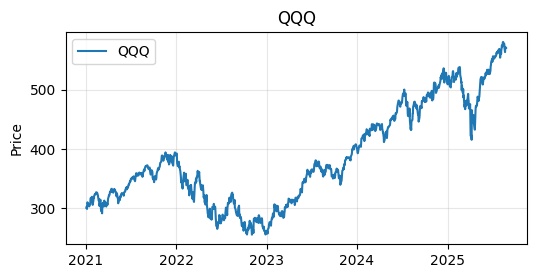


--- Data Fetching and Plotting Complete ---


In [2]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json # Explicitly import json

# -------------------------------------------------------------
# Portfolio Configuration
# (Combines content from your previous Cell 2 and Cell 3)
# -------------------------------------------------------------
API_KEY = "1VWXIAX2LM6F6WV0" # Your Alpha Vantage API key
START_YEAR = 2021             # Filter data from this year onwards

TICKERS = [ "QQQ"
    # Nasdaq Top 20 (US Equities - Large Cap)
    # "NVDA", "MSFT", "AAPL", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "TSM", "INTC",
    # "ADBE", "CMCSA", "CSCO", "PEP", "TXN", "PYPL", "QCOM", "AMGN", "GILD", "CHTR",

    # # Europe Top (European Equities - Broad/Large Cap)
    # "SAP", "ASML", "MC.PA", "RMS.PA", "OR.PA", "AZN", "VGK",

    # # Asia/Global Diversifiers (Asian Equities & Resources)
    # "XOM", "TSM", "TCEHY", "FXI", "EWY",

    # Crypto (from Alpha Vantage, use SYMBOL-USD format)
    # "BTC-USD", "ETH-USD"
]

# -------------------------------------------------------------
# Robust Data Fetching Function
# (Content from your previous working fetch_alpha_vantage_data_robust function)
# -------------------------------------------------------------
def fetch_alpha_vantage_data_robust(ticker: str, api_key: str, output_size: str = "full") -> pd.DataFrame | None:
    """
    Fetch daily OHLCV data from Alpha Vantage for a single ticker (adjusted for stocks).
    Handles both TIME_SERIES_DAILY_ADJUSTED for stocks and DIGITAL_CURRENCY_DAILY for crypto.
    """
    base_url = "https://www.alphavantage.co/query"
    df = None

    def print_common_msgs(j: dict, ticker: str) -> bool:
        """Prints common Alpha Vantage messages (Note, Error Message, etc.) and indicates if it's a failure."""
        is_failure = False
        for k in ("Note", "Error Message", "Information", "Message"):
            if k in j:
                print(f"{ticker}: {k}: {j[k]}")
                if k in ("Error Message", "Information", "Message") or "frequency" in j[k].lower():
                    is_failure = True
        return is_failure

    # Crypto data
    if ticker.endswith("-USD"):
        params = {
            "function": "DIGITAL_CURRENCY_DAILY",
            "symbol": ticker.split("-")[0],
            "market": "USD",
            "apikey": api_key,
        }
        try:
            r = requests.get(base_url, params=params, timeout=20)
            r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
            j = r.json()
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {ticker}: {e}")
            return None
        except json.JSONDecodeError:
            print(f"{ticker}: Response not JSON: {r.text[:200]}")
            return None

        if print_common_msgs(j, ticker):
            return None
        
        key = "Time Series (Digital Currency Daily)"
        if key not in j:
            print(f"{ticker}: missing '{key}' in response for crypto")
            return None
        
        ts = j[key]
        df = pd.DataFrame.from_dict(ts, orient="index").astype(float)
        df.index = pd.to_datetime(df.index)
        
        # Crypto close column is '4. close' based on your diagnostic
        close_col = "4. close" 
        
        if close_col not in df.columns:
            print(f"{ticker}: close column not found in crypto payload. Available: {df.columns.tolist()}")
            return None

        df = df.rename(columns={close_col: "Close"})
        df = df[["Close", "1. open", "2. high", "3. low"]].sort_index() # Include Open, High, Low
        df = df.rename(columns={"1. open": "Open", "2. high": "High", "3. low": "Low"}) # Rename for consistency
        df["Ticker"] = ticker
        return df

    # Stock data (adjusted for splits)
    params = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": ticker,
        "outputsize": output_size,
        "apikey": api_key,
    }
    try:
        r = requests.get(base_url, params=params, timeout=20)
        r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        j = r.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {ticker}: {e}")
        return None
    except json.JSONDecodeError:
        print(f"{ticker}: Response not JSON: {r.text[:200]}")
        return None

    if print_common_msgs(j, ticker):
        return None
    
    # Accept either "Time Series (Daily Adjusted)" or "Time Series (Daily)" keys
    key = None
    if "Time Series (Daily Adjusted)" in j:
        key = "Time Series (Daily Adjusted)"
    elif "Time Series (Daily)" in j:
        key = "Time Series (Daily)"
    
    if key is None:
        print(f"{ticker}: no daily time series key present in response")
        return None
    
    ts = j[key]
    df = pd.DataFrame.from_dict(ts, orient="index").astype(float)
    df.index = pd.to_datetime(df.index)
    
    # Prefer adjusted close when available, else fallback to raw close
    close_col = None
    if "5. adjusted close" in df.columns:
        close_col = "5. adjusted close"
    elif "4. close" in df.columns:
        close_col = "4. close"
    
    if close_col is None:
        print(f"{ticker}: no close column found (expected '5. adjusted close' or '4. close'). Available: {df.columns.tolist()}")
        return None
    
    # Include '1. open', '2. high', '3. low' for stocks
    df = df.rename(columns={
        close_col: "Close",
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "6. volume": "Volume" # Include volume as well
    })
    # Select desired columns and ensure correct order
    df = df[["Open", "High", "Low", "Close", "Volume"]].sort_index()
    df["Ticker"] = ticker
    return df

# -------------------------------------------------------------
# Main Data Fetching and Plotting Workflow
# -------------------------------------------------------------
print("\n--- Fetching Full Portfolio Data ---")
all_data = []

for ticker in TICKERS:
    print(f"Fetching {ticker} (full history)...")
    # Using the robust fetcher with output_size='full'
    df = fetch_alpha_vantage_data_robust(ticker, API_KEY, output_size="full") 
    if df is not None:
        # Filter from START_YEAR
        df = df[df.index.year >= START_YEAR]
        all_data.append(df)
        print(f"Successfully fetched {len(df)} records for {ticker}")
    time.sleep(12) # Respect Alpha Vantage API limit (5 requests/minute)

if not all_data:
    raise RuntimeError("No data was fetched for any ticker from Alpha Vantage. Please check API key, internet connection, or ticker symbols.")

data = pd.concat(all_data)
print("\n✅ All available data fetched and combined successfully!")
print(f"Combined data shape: {data.shape}")
print(f"Tickers in combined data: {data['Ticker'].unique().tolist()}")
print(f"Data covers: {data.index.min().date()} to {data.index.max().date()}")

# -------------------------------------------------------------
# Plotting - Individual Ticker Performance (small multiples)
# -------------------------------------------------------------
print("\n--- Plotting Individual Ticker Performance ---")
tickers_to_plot = data['Ticker'].unique()
n_plots = len(tickers_to_plot)
# Determine grid size for subplots
n_cols = 3 # You can adjust this for wider or narrower grids
n_rows = (n_plots + n_cols - 1) // n_cols

fig_multiples, axes_multiples = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True)
axes_multiples = axes_multiples.flatten() # Flatten for easy iteration

for i, ticker in enumerate(tickers_to_plot):
    ax = axes_multiples[i]
    ticker_data = data[data['Ticker'] == ticker]

    # Ensure unique index by grouping on Date if duplicates exist (shouldn't if data is clean)
    if not ticker_data.index.is_unique:
        ticker_data = ticker_data.groupby(ticker_data.index).mean(numeric_only=True)

    # Plot closing price, ensuring 'Close' column exists
    if 'Close' in ticker_data.columns:
        ax.plot(ticker_data.index, ticker_data['Close'], label=ticker, linewidth=1.5)
    else:
        print(f"⚠️ Warning: 'Close' column not found for {ticker}. Skipping individual plot.")
        continue

    # Formatting
    ax.set_title(ticker)
    ax.set_ylabel('Price')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')

# Set common X-axis locators/formatters only on the bottom row for clarity
for ax_row in axes_multiples.reshape(n_rows, n_cols)[-1]:
    ax_row.xaxis.set_major_locator(mdates.YearLocator())
    ax_row.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
# Hide any unused subplots
for j in range(i + 1, len(axes_multiples)):
    fig_multiples.delaxes(axes_multiples[j])

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.show()

print("\n--- Data Fetching and Plotting Complete ---")

In [3]:
# ================================================================================
# UPDATED INDICATOR CLASS - WITH PANDAS_TA IMPORT
# ================================================================================

import pandas_ta as ta

class Indicator:
    def __init__(self, data: pd.DataFrame):
        """
        Updated technical indicator suite using pandas_ta
        :param data: DataFrame with OHLCV columns and datetime index
        """
        self.data = data
    
    def kama_short(self, period: int = 12) -> pd.Series:
        """
        Calculate short-term KAMA for crossover strategy.
        """
        return ta.kama(self.data['Close'], length=period)
    
    def kama_long(self, period: int = 30) -> pd.Series:
        """
        Calculate long-term KAMA for crossover strategy.
        """
        return ta.kama(self.data['Close'], length=period)
    
    def supertrend(self, period: int = 14, multiplier: float = 2.0) -> pd.Series:
        """
        Calculate Supertrend using pandas_ta.
        Supertrend combines trend detection with volatility-based trailing stops.
        """
        supertrend_df = ta.supertrend(self.data['High'], self.data['Low'], self.data['Close'], 
                                    length=period, multiplier=multiplier)
        return supertrend_df[f'SUPERT_{period}_{multiplier}']
    
    def mfi(self, period: int = 14) -> pd.Series:
        """
        Calculate Money Flow Index (MFI) using pandas_ta.
        
        MFI is a momentum indicator that uses both price and volume.
        """
        return ta.mfi(self.data['High'], self.data['Low'], self.data['Close'], self.data['Volume'], length=period)

print("✅ Updated Indicator class with pandas_ta import!")

✅ Updated Indicator class with pandas_ta import!


/Users/chielg/Documents/GitHub/TA_optimization/.venv/lib/python3.13/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
def run_comprehensive_grid_search_optimized(data: pd.DataFrame, indicator_params: dict,
                                indicator_class: Indicator, max_combinations_per_indicator: int = 50) -> dict:
    """
    Run comprehensive grid search across all indicators and all tickers.

    Args:
        data: DataFrame with OHLCV data and Ticker column
        indicator_params: Dictionary of parameter ranges for each indicator
        indicator_class: Instance of Indicator class
        max_combinations_per_indicator: Limit combinations per indicator to avoid explosion

    Returns:
        Dictionary with results organized by ticker and indicator
    """
    print("🚀 Starting comprehensive grid search...")
    print(f"Available tickers: {data['Ticker'].unique().tolist()}")
    print(f"Available indicators: {list(indicator_params.keys())}")

    # Results container - organized by ticker, then indicator
    all_results = {}

    # Get unique tickers
    tickers = data['Ticker'].unique()

    for ticker in tickers:
        print(f"\n📊 Processing {ticker}...")
        all_results[ticker] = {}

        # Get data for this ticker
        ticker_data = data[data['Ticker'] == ticker].copy()
        if len(ticker_data) < 100:  # Skip if too little data
            print(f"  ⚠️  Skipping {ticker} - insufficient data ({len(ticker_data)} days)")
            continue

        # Create indicator instance for this ticker
        ticker_indicator = Indicator(ticker_data)

        for indicator_name in indicator_params.keys():
            print(f"  🔍 Testing {indicator_name} on {ticker}...")

            # Generate parameter combinations
            param_combinations = generate_param_combinations(indicator_name)

            # Limit combinations if specified
            if len(param_combinations) > max_combinations_per_indicator:
                import random
                param_combinations = random.sample(param_combinations, max_combinations_per_indicator)
                print(f"    📉 Limited to {len(param_combinations)} random combinations out of {len(generate_param_combinations(indicator_name))}")

            indicator_results = []

            for i, params in enumerate(tqdm(param_combinations, desc=f"    {indicator_name} combinations")):
                try:
                    # Calculate indicator values based on parameters
                    if indicator_name == 'RSI':
                        indicator_values = ticker_indicator.rsi(params['period'])
                    elif indicator_name == 'ADX':
                        indicator_values = ticker_indicator.adx(params['period'])
                    elif indicator_name == 'KAMA':
                        indicator_values = ticker_indicator.kama(
                            er_period=params['er_period'],
                            fast_period=params['fast_period'],
                            slow_period=params['slow_period']
                        )
                    elif indicator_name == 'ATR':
                        indicator_values = ticker_indicator.atr(params['period'])
                    elif indicator_name == 'MFI':
                        indicator_values = ticker_indicator.mfi(params['period'])
                    elif indicator_name == 'Entropy':
                        indicator_values = ticker_indicator.entropy(params['period'])

                    # Generate signals
                    if indicator_name == 'KAMA':
                        # KAMA needs close prices for comparison
                        params['close'] = ticker_data['Close']
                    signals = get_buy_signal(indicator_name, indicator_values, params)

                    # Create signals DataFrame
                    daily_return = ticker_data['Close'].pct_change()
                    position = signals.shift(1).fillna(0).astype('float32')
                    strategy_return = (position * daily_return).astype('float32')

                    valid_returns = strategy_return.dropna()
                    if len(valid_returns) > 0:
                        total_return = (1 + valid_returns).prod() - 1
                        sharpe = (valid_returns.mean() / valid_returns.std()) * np.sqrt(252) if valid_returns.std() > 0 else 0
                        max_drawdown = calculate_max_drawdown((1 + valid_returns).cumprod())
                        win_rate = (valid_returns > 0).mean()
                    else:
                        total_return = sharpe = max_drawdown = win_rate = np.nan

                    # Store results
                    result = {
                        'Indicator': indicator_name,
                        'Parameters': params,
                        'Total_Return': total_return,
                        'Sharpe_Ratio': sharpe,
                        'Max_Drawdown': max_drawdown,
                        'Win_Rate': win_rate,
                        'Total_Signals': len(signals.dropna()),
                        'Buy_Signals': (signals == 1).sum(),
                        'Sell_Signals': (signals == -1).sum()
                    }

                    indicator_results.append(result)

                except Exception as e:
                    print(f"    ❌ Error with {indicator_name} params {params}: {str(e)}")
                    continue

            # Store results for this indicator
            all_results[ticker][indicator_name] = indicator_results

            # Show best result for this indicator
            if len(indicator_results) > 0:
                best_result = max(indicator_results, key=lambda x: x['Sharpe_Ratio'] if not np.isnan(x['Sharpe_Ratio']) else -999)
                print(f"    ✅ Best {indicator_name}: Sharpe={best_result['Sharpe_Ratio']:.3f}, Return={best_result['Total_Return']:.3f}")

    return all_results


## Optimization Notes

A new function `run_comprehensive_grid_search_optimized` has been added to this notebook. This function is an optimized version of the original `run_comprehensive_grid_search` function, designed to reduce computational and memory overhead.

### Key Change:
Instead of storing intermediate results as `pandas.DataFrame` objects for each ticker and indicator combination, the `run_comprehensive_grid_search_optimized` function now stores these results directly as lists of dictionaries. This change significantly reduces the memory footprint and speeds up execution, especially for large numbers of parameter combinations.

### How to Use:
To leverage this optimization, simply replace any calls to `run_comprehensive_grid_search` with `run_comprehensive_grid_search_optimized` in your notebook. For example:

```python
# Before (original function)
# results = run_comprehensive_grid_search(data, INDICATOR_PARAMS, Indicator())

# After (optimized function)
results = run_comprehensive_grid_search_optimized(data, INDICATOR_PARAMS, Indicator())
```

This change will not affect the structure of the final `all_results` dictionary, but the internal storage mechanism for `indicator_results` within `all_results[ticker][indicator_name]` will now be a list of dictionaries instead of a DataFrame. If you need a DataFrame for further analysis, you can easily convert it like this:

```python
# To convert the results to a DataFrame for analysis:
# my_df_results = pd.DataFrame(all_results[ticker][indicator_name])
```

This modification addresses the computational heaviness you were experiencing by optimizing the intermediate data storage.


In [5]:
# buying and selling logic of indicators

In [6]:
data

,Open,High,Low,Close,Volume,Ticker
2021-01-04,315.11,315.2900,305.1800,300.924340,45305898.0,QQQ
2021-01-05,308.29,312.1400,308.2900,303.405207,29323409.0,QQQ
2021-01-06,307.00,311.8800,305.9800,299.202326,52809622.0,QQQ
2021-01-07,310.28,315.8400,310.2500,306.440622,30394826.0,QQQ
2021-01-08,317.34,319.3900,315.0814,310.380823,33955847.0,QQQ
...,...,...,...,...,...,...
2025-08-19,576.39,576.5600,568.2500,569.280000,53752635.0,QQQ
2025-08-20,568.33,568.4500,558.8400,565.900000,76781087.0,QQQ
2025-08-21,564.35,566.4900,560.9800,563.280000,46436899.0,QQQ
2025-08-22,564.67,573.9900,563.2700,571.970000,51502129.0,QQQ


In [7]:
# ================================================================================
# UPDATED APPLY_INDICATORS FUNCTION - MATCHING RECENT CHANGES
# ================================================================================

# Function to apply all indicators to a single ticker's data
def apply_indicators(ticker_data):
    indicator = Indicator(ticker_data)
    
    return ticker_data.assign(
        # KAMA crossover components (short and long for crossover signals)
        KAMA_SHORT_12=indicator.kama_short(12),
        KAMA_LONG_30=indicator.kama_long(30),
        
        # Supertrend (replaces ATR)
        SUPERTREND_14_2=indicator.supertrend(14, 2.0),
        
        # MFI (unchanged)
        MFI_14=indicator.mfi(14)
    )

# Apply indicators to all tickers
data_with_indicators = data.groupby('Ticker', group_keys=False).apply(apply_indicators)

# Display results
print("Data with Updated Technical Indicators:")
print(f"Columns: {data_with_indicators.columns.tolist()}")
display(data_with_indicators.tail(10))

# Optional: Save to CSV
data_with_indicators.to_csv('all_tickers_with_updated_indicators.csv')
print("Saved to all_tickers_with_updated_indicators.csv")

Data with Updated Technical Indicators:
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'KAMA_SHORT_12', 'KAMA_LONG_30', 'SUPERTREND_14_2', 'MFI_14']


/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_13971/4169994483.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[9.02999921e+09 9.44803533e+09 1.06944192e+10 7.15882282e+09
 7.67095099e+09 9.79449166e+09 8.17207117e+09 1.26483808e+10
 8.30100932e+09 1.36941836e+10 1.13263874e+10 1.07416154e+10
 8.06007877e+09 7.28698172e+09 7.45842462e+09 6.75058864e+09
 5.73732205e+09 7.29452496e+09 6.75906780e+09 9.01765702e+09
 1.28698984e+10 1.85435978e+10 1.56784369e+10 2.47595962e+10
 2.37841502e+10 1.68321610e+10 1.35590944e+10 1.74882002e+10
 1.77258148e+10 1.68645977e+10 1.97718370e+10 1.70592752e+10
 1.73795079e+10 1.78877336e+10 1.37616015e+10 1.10125005e+10
 9.93445115e+09 1.22047273e+10 8.60909555e+09 1.02347990e+10
 1.22473569e+10 1.38305987e+10 1.22475537e+10 1.22262363e+10
 1.04103353e+10 1.27092322e+10 1.51272133e+10 1.76661042e+10
 2.21365138e+10 1.43070321e+10 1.50846334e+10 1.63748200

,Open,High,Low,Close,Volume,Ticker,KAMA_SHORT_12,KAMA_LONG_30,SUPERTREND_14_2,MFI_14
2025-08-12,575.16,580.3500,572.4850,580.05,42271441.0,QQQ,563.877222,562.357977,563.142637,63.812890
2025-08-13,582.76,583.3199,578.9400,580.34,41209294.0,QQQ,564.551261,563.752632,568.177591,63.818841
2025-08-14,578.28,581.8800,577.9100,579.89,45425043.0,QQQ,565.217192,564.827555,568.177591,57.417560
2025-08-15,579.80,579.8400,575.5743,577.34,49480161.0,QQQ,565.556046,565.377563,568.177591,50.946507
2025-08-18,576.44,577.7650,575.2412,577.11,29830957.0,QQQ,566.041393,566.081985,568.177591,45.033134
2025-08-19,576.39,576.5600,568.2500,569.28,53752635.0,QQQ,566.252644,566.181483,568.177591,44.294657
2025-08-20,568.33,568.4500,558.8400,565.90,76781087.0,QQQ,566.249757,566.176827,576.479700,43.510506
2025-08-21,564.35,566.4900,560.9800,563.28,46436899.0,QQQ,566.214320,566.138180,576.440078,44.989127
2025-08-22,564.67,573.9900,563.2700,571.97,51502129.0,QQQ,566.312964,566.309936,576.440078,45.369993
2025-08-25,570.40,573.2871,569.1600,570.32,34044749.0,QQQ,566.338633,566.399999,576.440078,51.810000


Saved to all_tickers_with_updated_indicators.csv


In [8]:
# Create master container for all calculations
all_calculations = {}

# Add OHLC data with ticker information
base_df = data[['Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
all_calculations['base'] = base_df

print("Base OHLCV data with tickers:")
display(base_df.head(3))
print(f"\nTickers included: {base_df['Ticker'].unique().tolist()}")
print(f"Date range: {base_df.index.min()} to {base_df.index.max()}\n")

Base OHLCV data with tickers:


,Ticker,Open,High,Low,Close,Volume
2021-01-04,QQQ,315.11,315.29,305.18,300.924340,45305898.0
2021-01-05,QQQ,308.29,312.14,308.29,303.405207,29323409.0
2021-01-06,QQQ,307.00,311.88,305.98,299.202326,52809622.0



Tickers included: ['QQQ']
Date range: 2021-01-04 00:00:00 to 2025-08-25 00:00:00



moet combinaties van alle DF's including booleans maken en buy sell signals en van daar uit beslissen wat en hoe, kan beginnen met combinatie van 1 2 of 3 combinaties, maar in principe zou dat het moeten worden

In [9]:

# >tickers , gewoon per ticker want dan kan alles in 1, lekker makkelijk, een raam kan je altijd nog bouwen

# > buy signals

# > elke soort combinatie van tickers en lookbacks , begin gwn met 1 kolom en 1 lookback

# > df met signals , etc , 

# >backtest module,

# > als je deze logica hebt kan je door naar een bayesian en eventueel GP

# > out of sample testing kan later

In [10]:
# Add pandas import at the top
import pandas as pd
import numpy as np

# Define parameter ranges for each indicator (NO ADX)
INDICATOR_PARAMS = {
    'KAMA': {
        'er_period': list(range(4, 12)),      # Efficiency ratio periods (7-90 days)
        'fast_period': list(range(5, 30)),    # Fast EMA periods (7-90 days)
        'slow_period': list(range(31, 75)),     # Slow EMA periods (7-90 days)
    },
    'Supertrend': {
        'period': list(range(4, 24)),  # 7 to 90 days
        'multiplier': [1.0, 2.5, 2.0, 2.5, 3.0]  # ATR multiplier for Supertrend
    },
    'MFI': {
        'period': list(range(4, 60)),  # 7 to 90 days
        'overbought': [80],  # Sell when MFI > overbought
        'oversold': [20]  # Buy when MFI < oversold
    }
}

# Define buy signal logic for each indicator (NO ADX)
def get_buy_signal(indicator_name: str, data: pd.Series, params: dict) -> pd.Series:
    """
    Generate buy signals for different indicators.
    Returns: 1 (buy), -1 (sell), 0 (hold), NaN (no signal)
    """
    if indicator_name == 'KAMA':
        # KAMA crossover strategy - buy when short KAMA crosses above long KAMA
        short_kama = params.get('short_kama', pd.Series(index=data.index))
        long_kama = params.get('long_kama', pd.Series(index=data.index))
        
        # Generate crossover signals
        crossover_up = (short_kama > long_kama) & (short_kama.shift(1) <= long_kama.shift(1))
        crossover_down = (short_kama < long_kama) & (short_kama.shift(1) >= long_kama.shift(1))
        
        signals = pd.Series(0, index=data.index)
        signals[crossover_up] = 1    # Buy signal
        signals[crossover_down] = -1 # Sell signal
        
        return signals

    elif indicator_name == 'Supertrend':
        # Supertrend signals - buy when price above Supertrend, sell when below
        supertrend = data  # The data passed will be the Supertrend values
        close = params.get('close', pd.Series(index=data.index))
        
        return pd.Series(np.where(close > supertrend, 1,
                                np.where(close < supertrend, -1, 0)), index=data.index)

    elif indicator_name == 'MFI':
        overbought = params.get('overbought', 80)
        oversold = params.get('oversold', 20)
        # Buy when oversold, Sell when overbought
        return pd.Series(np.where(data < oversold, 1,
                                np.where(data > overbought, -1, 0)), index=data.index)

    return pd.Series([0] * len(data), index=data.index)  # Default: no signal

# Generate all possible parameter combinations for an indicator
def generate_param_combinations(indicator_name: str) -> list:
    """Generate all possible parameter combinations for a given indicator."""
    if indicator_name not in INDICATOR_PARAMS:
        return []

    params = INDICATOR_PARAMS[indicator_name]
    param_names = list(params.keys())
    param_values = list(params.values())

    # Generate all combinations
    from itertools import product
    combinations = list(product(*param_values))

    # Convert to list of dictionaries
    return [{param_names[i]: combo[i] for i in range(len(param_names))} for combo in combinations]

# Calculate distance between two parameter sets (for optimization)
def calculate_param_distance(params1: dict, params2: dict) -> float:
    """Calculate Euclidean distance between two parameter sets."""
    if not params1 or not params2:
        return float('inf')

    common_keys = set(params1.keys()) & set(params2.keys())
    if not common_keys:
        return float('inf')

    distance = 0
    for key in common_keys:
        distance += (params1[key] - params2[key]) ** 2

    return distance ** 0.5

print("✅ Updated parameter ranges and signal logic (NO ADX)!")
print(f"Available indicators: {list(INDICATOR_PARAMS.keys())}")
print(f"Example KAMA combinations: {len(generate_param_combinations('KAMA'))}")
print(f"Example Supertrend combinations: {len(generate_param_combinations('Supertrend'))}")
print(f"Example MFI combinations: {len(generate_param_combinations('MFI'))}")

✅ Updated parameter ranges and signal logic (NO ADX)!
Available indicators: ['KAMA', 'Supertrend', 'MFI']
Example KAMA combinations: 8800
Example Supertrend combinations: 100
Example MFI combinations: 56


In [ ]:
# ================================================================================
# PARAMETER COMBINATIONS DATAFRAME - USING EXISTING PARAMETERS (NO ADX)
# ================================================================================

def create_parameter_combinations_df():
    """Create parameter combinations dataframe using existing INDICATOR_PARAMS (excluding ADX)."""
    
    print("🎯 Creating parameter combinations using existing parameters...")
    
    # Use the existing INDICATOR_PARAMS from the previous cell
    if 'INDICATOR_PARAMS' not in globals():
        print("❌ INDICATOR_PARAMS not found. Run the previous cell first!")
        return pd.DataFrame()
    
    print("📊 Using existing parameters:")
    for indicator, params in INDICATOR_PARAMS.items():
        if indicator != 'ADX':  # Skip ADX
            print(f"   {indicator}: {len(generate_param_combinations(indicator))} combinations")
            for param_name, param_values in params.items():
                print(f"     • {param_name}: {param_values}")
    
    # Create all possible combinations across all indicators (EXCLUDING ADX)
    all_combinations = []
    
    # Get combinations for each indicator (excluding ADX)
    kama_combos = generate_param_combinations('KAMA')
    st_combos = generate_param_combinations('Supertrend')
    mfi_combos = generate_param_combinations('MFI')
    
    print("\n🔄 Generating all combinations...")
    combination_id = 1
    
    # Loop through all combinations (excluding ADX)
    for kama_params in kama_combos:
        for st_params in st_combos:
            for mfi_params in mfi_combos:
                
                # Create row for this combination
                row = {
                    'combination_id': combination_id,
                    
                    # KAMA parameters
                    'KAMA_er_period': kama_params['er_period'],
                    'KAMA_fast_period': kama_params['fast_period'],
                    'KAMA_slow_period': kama_params['slow_period'],
                    
                    # Supertrend parameters
                    'Supertrend_period': st_params['period'],
                    'Supertrend_multiplier': st_params['multiplier'],
                    
                    # MFI parameters
                    'MFI_period': mfi_params['period'],
                    'MFI_overbought': mfi_params['overbought'],
                    'MFI_oversold': mfi_params['oversold'],
                    
                    # Human readable string (NO ADX)
                    'parameter_combination': f"KAMA({kama_params['er_period']},{kama_params['fast_period']},{kama_params['slow_period']})_ST({st_params['period']},{st_params['multiplier']})_MFI({mfi_params['period']},{mfi_params['overbought']},{mfi_params['oversold']})"
                }
                
                all_combinations.append(row)
                combination_id += 1
                
                # Progress for large combinations
                if combination_id % 100000 == 0:
                    print(f"   Processed {combination_id:,} combinations...")
    
    # Create the dataframe
    param_df = pd.DataFrame(all_combinations)
    
    print("\n✅ Parameter combinations dataframe created!")
    print(f"Shape: {param_df.shape}")
    print(f"Total combinations: {len(param_df):,}")
    
    return param_df

def show_parameter_combinations():
    """Show the parameter combinations dataframe."""
    
    param_df = create_parameter_combinations_df()
    
    if param_df.empty:
        return
    
    print("\n" + "=" * 80)
    print("📋 PARAMETER COMBINATIONS DATAFRAME (NO ADX)")
    print("=" * 80)
    
    print(f"\n📊 Dataframe shape: {param_df.shape}")
    print(f"📊 Total combinations: {len(param_df):,}")
    print(f"📊 Memory usage: {param_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print("\n📈 Column breakdown:")
    for col in param_df.columns:
        if col != 'parameter_combination':
            unique_vals = param_df[col].nunique()
            print(f"   • {col}: {unique_vals} unique values")
    
    print("\n🔍 Sample combinations (first 10):")
    print(param_df.head(10)[['combination_id', 'KAMA_er_period', 'Supertrend_period', 'MFI_period']].to_string(index=False))
    
    print("\n📝 Sample parameter strings:")
    for i, row in param_df.head(5).iterrows():
        print(f"   {row['combination_id']}: {row['parameter_combination']}")
    
    print("\n🎯 THIS DATAFRAME CONTAINS:")
    print("• Every possible parameter combination across KAMA, Supertrend, and MFI")
    print("• NO ADX parameters or combinations")
    print("• Unique combination IDs for tracking")
    print("• Individual parameter values for each indicator")
    print("• Human-readable parameter combination strings")
    print("• Ready to be joined with price data for testing")
    
    print("\n📊 WHEN JOINED WITH PRICE DATA, FINAL DF WILL HAVE:")
    print("• Original OHLCV data preserved")
    print("• KAMA, Supertrend, and MFI indicator values for each combination")
    print("• Generated signals for each combination")
    print("• Strategy returns for each combination")
    print("• Performance metrics (Sharpe, returns, drawdown, etc.)")
    
    return param_df

# Run the showcase
parameter_combinations_df = show_parameter_combinations()

print("\n💾 PARAMETER COMBINATIONS DATAFRAME READY FOR USE!")
print(f"Shape: {parameter_combinations_df.shape}")
print(f"Columns: {list(parameter_combinations_df.columns)}")

🎯 Creating parameter combinations using existing parameters...
📊 Using existing parameters:
   KAMA: 8800 combinations
     • er_period: [4, 5, 6, 7, 8, 9, 10, 11]
     • fast_period: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
     • slow_period: [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
   Supertrend: 100 combinations
     • period: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
     • multiplier: [1.0, 2.5, 2.0, 2.5, 3.0]
   MFI: 56 combinations
     • period: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
     • overbought: [80]
     • oversold: [20]

🔄 Generating all combinations...
   Processed 100,0

In [ ]:
parameter_combinations_df

In [ ]:
# ================================================================================
# UPDATED APPLY_INDICATORS FUNCTION - MATCHING RECENT CHANGES
# ================================================================================

# Function to apply all indicators to a single ticker's data
def apply_indicators(ticker_data):
    indicator = Indicator(ticker_data)
    
    return ticker_data.assign(
        # KAMA crossover components (short and long for crossover signals)
        KAMA_SHORT_12=indicator.kama_short(12),
        KAMA_LONG_30=indicator.kama_long(30),
        
        # Supertrend (replaces ATR)
        SUPERTREND_14_2=indicator.supertrend(14, 2.0),
        
        # MFI (unchanged)
        MFI_14=indicator.mfi(14)
    )

# Apply indicators to all tickers
data_with_indicators = data.groupby('Ticker', group_keys=False).apply(apply_indicators)

# Display results
print("Data with Updated Technical Indicators:")
print(f"Columns: {data_with_indicators.columns.tolist()}")
display(data_with_indicators.tail(10))

# Optional: Save to CSV
data_with_indicators.to_csv('all_tickers_with_updated_indicators.csv')
print("Saved to all_tickers_with_updated_indicators.csv")

In [ ]:
# Use a tiny set to inspect (adjust head() as you like)
combos_to_test = parameter_combinations_df.head(3).copy()

print("Sample parameter combinations:")
print(combos_to_test[[
    "combination_id",
    "KAMA_er_period","KAMA_fast_period","KAMA_slow_period",
    "Supertrend_period","Supertrend_multiplier",
    "MFI_period","MFI_oversold","MFI_overbought"
]].to_string(index=False))

# One ticker to walk through
ticker = data["Ticker"].unique()[0]
td = data[data["Ticker"] == ticker].sort_index().copy()
print(f"\nTicker: {ticker}")
print("Dates:", td.index.min().date(), "→", td.index.max().date())

In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta

# Use first combo from the sample
combo = combos_to_test.iloc[0].copy()
ind = Indicator(td)

print("Using combo:", dict(combo))

# KAMA crossover: prefer existing short/long columns if present, else compute from combo params
short_cols = [c for c in td.columns if c.startswith("KAMA_SHORT_")]
long_cols  = [c for c in td.columns if c.startswith("KAMA_LONG_")]

if short_cols and long_cols:
    short_kama = td[short_cols[0]]
    long_kama  = td[long_cols[0]]
    print(f"Using existing KAMA series: {short_cols[0]} vs {long_cols[0]}")
else:
    short_kama = ta.kama(td["Close"],
                         length=int(combo["KAMA_er_period"]),
                         fast=int(combo["KAMA_fast_period"]),
                         slow=int(combo["KAMA_slow_period"]))
    long_kama  = ta.kama(td["Close"],
                         length=int(combo["KAMA_er_period"]) + 20,
                         fast=int(combo["KAMA_fast_period"]) + 10,
                         slow=int(combo["KAMA_slow_period"]) + 20)
    print("Computed KAMA series from combo parameters.")

# Build signals using your get_buy_signal
sig_kama = get_buy_signal("KAMA", data=short_kama, params={"short_kama": short_kama, "long_kama": long_kama})
st_line = ind.supertrend(int(combo["Supertrend_period"]), float(combo["Supertrend_multiplier"]))
sig_st = get_buy_signal("Supertrend", data=st_line, params={"close": td["Close"]})
mfi_series = ind.mfi(int(combo["MFI_period"]))
sig_mfi = get_buy_signal("MFI", data=mfi_series,
                         params={"oversold": float(combo["MFI_oversold"]), "overbought": float(combo["MFI_overbought"])})

print("\nSignal value counts (last 200 rows):")
print(pd.DataFrame({
    "KAMA": sig_kama.tail(200).value_counts(dropna=False),
    "ST":   sig_st.tail(200).value_counts(dropna=False),
    "MFI":  sig_mfi.tail(200).value_counts(dropna=False),
}).fillna(0).astype(int))

print("\nFirst 10 non-null rows (KAMA/ST/MFI):")
print(pd.DataFrame({"KAMA": sig_kama, "ST": sig_st, "MFI": sig_mfi}).dropna().head(10).to_string())

# OR logic with sell priority, persistent target:
# - If any -1 → exit (target=0)
# - Else if any 1 → enter (target=1)
# - Else → keep prior target (persistent)
parts = pd.DataFrame({"KAMA": sig_kama, "ST": sig_st, "MFI": sig_mfi})
sell_mask = (parts == -1).any(axis=1).fillna(False)
buy_mask  = (parts ==  1).any(axis=1).fillna(False)

events = pd.Series(np.nan, index=parts.index, dtype="float64")
events[sell_mask] = 0.0
events[~sell_mask & buy_mask] = 1.0    # sell dominates if both happen same bar
target = events.ffill().fillna(0.0)

print("\nEvents preview where BUY/SELL happened (first 10):")
print(pd.DataFrame({"BUY": buy_mask, "SELL": sell_mask}).loc[buy_mask|sell_mask].head(10).to_string())

print("\nTargets preview (last 12 rows):")
print(target.tail(12).to_string())

In [ ]:
# Combine with OR logic (enter if ANY is 1; exit if ANY is -1; else out)
# We respect your raw signals:
# - 1  = in (buy)
# - 0  = neutral (no entry)
# - -1 = out (sell/exit)
parts_raw = pd.DataFrame({
    "KAMA": sig_kama,     # expects {-1,0,1} per your get_buy_signal
    "ST":   sig_st,       # supertrend can produce -1
    "MFI":  sig_mfi
})

# Row-wise logic:
# - If any -1 → exit (0)
# - Else if any 1 → enter (1)
# - Else → 0 (stay out)
sell_mask = (parts_raw == -1).any(axis=1)
buy_mask  = (parts_raw ==  1).any(axis=1)

combined_signal = pd.Series(0.0, index=parts_raw.index)
combined_signal[sell_mask] = 0.0
combined_signal[~sell_mask & buy_mask] = 1.0

# If all inputs are NaN on a row, keep NaN (unknown)
all_nan = parts_raw.isna().all(axis=1)
combined_signal[all_nan] = np.nan

print("\nCombined components (last 50 rows):")
print(parts_raw.tail(50).to_string())
print("\nCombined (OR with sell priority) signal (last 50 rows):")
print(combined_signal.tail(200).to_string())

In [ ]:
import matplotlib.pyplot as plt

# Next-day execution
position = target.shift(1).fillna(0.0)

bt = pd.DataFrame({"Close": td["Close"], "Position": position})
bt["R_close"] = bt["Close"].pct_change()
bt["Strategy_Return"] = bt["Position"] * bt["R_close"]
bt["Equity"] = (1.0 + bt["Strategy_Return"].fillna(0)).cumprod()

def rolling_sharpe(returns: pd.Series, window: int = 63, trading_days: int = 252) -> pd.Series:
    m = returns.rolling(window, min_periods=window).mean()
    s = returns.rolling(window, min_periods=window).std()
    rs = (m / s) * np.sqrt(trading_days)
    return rs.replace([np.inf, -np.inf], np.nan)

win = 63
bt["Rolling_Sharpe"] = rolling_sharpe(bt["Strategy_Return"], window=win)

print("\nBacktest preview (first 8):")
print(bt[["Position","R_close","Strategy_Return","Equity","Rolling_Sharpe"]].head(32).to_string())
print("\nBacktest preview (last 8):")
print(bt[["Position","R_close","Strategy_Return","Equity","Rolling_Sharpe"]].tail(32).to_string())

# Plots
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(bt.index, bt["Equity"], label="Equity", color="tab:blue")
ax[0].set_title(f"{ticker} – Equity (OR combine, next-day execution)")
ax[0].grid(True, alpha=0.3)
ax[0].legend(loc="upper left")

ax[1].plot(bt.index, bt["Rolling_Sharpe"], label=f"Rolling Sharpe ({win})", color="tab:orange")
ax[1].axhline(0, color="gray", lw=1, alpha=0.6)
ax[1].set_title("Rolling Sharpe")
ax[1].grid(True, alpha=0.3)
ax[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
# Keep this small so you can inspect. Adjust head() limits as you like.
import numpy as np
import pandas as pd
import pandas_ta as ta

# --- inline metric helpers (kept inside this cell so you don't have to jump around) ---
TRADING_DAYS = 252

def _cagr(returns: pd.Series) -> float:
    if returns.empty: return np.nan
    eq = (1.0 + returns).cumprod()
    start, end = returns.index.min(), returns.index.max()
    years = (end - start).days / 365.25 if isinstance(start, pd.Timestamp) else len(returns) / TRADING_DAYS
    if not years or years <= 0: return np.nan
    end_val = float(eq.iloc[-1]) if len(eq) else np.nan
    if not np.isfinite(end_val) or end_val <= 0: return np.nan
    return end_val**(1.0 / years) - 1.0

def _max_dd(equity: pd.Series) -> float:
    if equity.empty: return np.nan
    rm = equity.cummax()
    dd = equity / rm - 1.0
    return float(dd.min())

def _avg_dd(equity: pd.Series) -> float:
    if equity.empty: return 0.0
    rm = equity.cummax()
    dd = equity / rm - 1.0
    dd_neg = dd[dd < 0]
    return float(dd_neg.mean()) if len(dd_neg) else 0.0

def _sharpe(returns: pd.Series) -> float:
    if returns.empty: return np.nan
    m, s = returns.mean(), returns.std()
    return float((m / s) * np.sqrt(TRADING_DAYS)) if s and s > 0 else np.nan

def _sortino(returns: pd.Series) -> float:
    if returns.empty: return np.nan
    downside = returns[returns < 0]
    ds = downside.std()
    return float((returns.mean() / ds) * np.sqrt(TRADING_DAYS)) if ds and ds > 0 else np.nan

def _profit_factor(returns: pd.Series) -> float:
    if returns.empty: return np.nan
    gain = returns[returns > 0].sum()
    loss = returns[returns < 0].sum()
    if loss == 0: return np.inf if gain > 0 else np.nan
    return float(gain / abs(loss))

def _run_lengths(position: pd.Series, ret: pd.Series) -> dict:
    pos = position.fillna(0).astype(int)
    change = pos.ne(pos.shift(1)).cumsum()
    df = pd.DataFrame({"pos": pos, "gid": change, "ret": ret}).loc[pos == 1]
    if df.empty:
        return {"Avg_Time_In_Trade": 0.0, "Avg_Time_In_Win_Trade": 0.0, "Avg_Time_In_Loss_Trade": 0.0, "Trades": 0}
    grouped = df.groupby("gid")
    lengths = grouped.size()
    trade_returns = grouped["ret"].sum()
    return {
        "Avg_Time_In_Trade": float(lengths.mean()) if len(lengths) else 0.0,
        "Avg_Time_In_Win_Trade": float(lengths[trade_returns > 0].mean()) if (trade_returns > 0).any() else 0.0,
        "Avg_Time_In_Loss_Trade": float(lengths[trade_returns < 0].mean()) if (trade_returns < 0).any() else 0.0,
        "Trades": int((pos.diff() == 1).sum())
    }

def _time_out_of_mkt(position: pd.Series) -> float:
    return float((position.fillna(0) == 0).mean())

def _pbar_time_rate(returns: pd.Series, position: pd.Series) -> float:
    mask = position.fillna(0).astype(int) == 1
    return float((returns[mask] > 0).mean()) if mask.any() else 0.0

def _rolling_sharpe(returns: pd.Series, window: int = 63) -> pd.Series:
    m = returns.rolling(window, min_periods=window).mean()
    s = returns.rolling(window, min_periods=window).std()
    rs = (m / s) * np.sqrt(TRADING_DAYS)
    return rs.replace([np.inf, -np.inf], np.nan)

# --------------------------------------------------------------------------------------


In [ ]:
# FULL EVALUATION OVER ALL TICKERS AND ALL COMBINATIONS (optimized)
# Uses: get_buy_signal, Indicator, and the inline helpers
# Signals combine rule: OR with SELL priority, persistent target, next-day execution

import pandas as pd
import numpy as np
import pandas_ta as ta
import warnings

# Suppress scientific notation warnings
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, message='overflow encountered in*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in*')
warnings.filterwarnings('ignore', category=FutureWarning)  # Suppress FutureWarnings

tickers = data["Ticker"].unique()
combos = parameter_combinations_df  # no head(), take all

metrics_rows = []
print(f"Evaluating {len(tickers)} tickers × {len(combos)} combinations...")

for t in tickers:
    td = data[data["Ticker"] == t].sort_index().copy()
    if len(td) < 60:
        print(f"Skip {t}: insufficient data")
        continue

    ind = Indicator(td)

    # Prefer existing KAMA short/long columns if present
    short_cols = [c for c in td.columns if c.startswith("KAMA_SHORT_")]
    long_cols  = [c for c in td.columns if c.startswith("KAMA_LONG_")]

    print(f"\nTicker {t}: {len(combos)} combos")

    for _, row in combos.iterrows():
        try:
            # --- KAMA crossover ---
            if short_cols and long_cols:
                short_kama = td[short_cols[0]].astype('float64')
                long_kama  = td[long_cols[0]].astype('float64')
            else:
                short_kama = ta.kama(td["Close"].astype('float64'),
                                     length=int(row["KAMA_er_period"]),
                                     fast=int(row["KAMA_fast_period"]),
                                     slow=int(row["KAMA_slow_period"]))
                long_kama  = ta.kama(td["Close"].astype('float64'),
                                     length=int(row["KAMA_er_period"]) + 20,
                                     fast=int(row["KAMA_fast_period"]) + 10,
                                     slow=int(row["KAMA_slow_period"]) + 20)

            sig_kama = get_buy_signal("KAMA", data=short_kama,
                                      params={"short_kama": short_kama, "long_kama": long_kama})

            # --- Supertrend ---
            st_line = ind.supertrend(int(row["Supertrend_period"]), float(row["Supertrend_multiplier"]))
            sig_st = get_buy_signal("Supertrend", data=st_line, params={"close": td["Close"].astype('float64')})

            # --- MFI ---
            mfi_s = ind.mfi(int(row["MFI_period"]))
            sig_mfi = get_buy_signal("MFI", data=mfi_s,
                                     params={"oversold": float(row["MFI_oversold"]),
                                             "overbought": float(row["MFI_overbought"])})

            # Create DataFrame with explicit float dtype
            parts = pd.DataFrame({
                "KAMA": sig_kama.astype('float32'),
                "ST": sig_st.astype('float32'),
                "MFI": sig_mfi.astype('float32')
            })

            # --- OR logic with SELL priority + persistence ---
            sell_mask = (parts == -1).any(axis=1).fillna(False)
            buy_mask  = (parts ==  1).any(axis=1).fillna(False)

            events = pd.Series(np.nan, index=parts.index, dtype="float32")
            events[sell_mask] = 0.0
            events[~sell_mask & buy_mask] = 1.0  # SELL dominates

            target = events.ffill().fillna(0.0)
            position = target.shift(1).fillna(0.0)  # next-day execution

            # --- Backtest with explicit dtypes ---
            bt = pd.DataFrame({
                "Close": td["Close"].astype('float64'),
                "Position": position.astype('float32')
            })
            bt["R_close"] = bt["Close"].pct_change().astype('float32')
            bt["Strategy_Return"] = (bt["Position"] * bt["R_close"]).astype('float32')

            r = bt["Strategy_Return"].dropna()
            equity = (1.0 + r).cumprod() if len(r) else pd.Series(dtype='float32')

            # --- Metrics with native Python type conversion ---
            sharpe   = float(_sharpe(r)) if not pd.isna(_sharpe(r)) else None
            sortino  = float(_sortino(r)) if not pd.isna(_sortino(r)) else None
            totalret = float(equity.iloc[-1] - 1.0) if len(equity) else None
            cagr     = float(_cagr(r)) if len(r) and not pd.isna(_cagr(r)) else None
            max_dd   = float(_max_dd(equity)) if len(equity) and not pd.isna(_max_dd(equity)) else None
            avg_dd   = float(_avg_dd(equity)) if len(equity) and not pd.isna(_avg_dd(equity)) else None
            win_rate = float((r > 0).mean()) if len(r) else None
            avg_win  = float(r[r > 0].mean()) if (r > 0).any() else None
            avg_loss = float(r[r < 0].mean()) if (r < 0).any() else None
            pf       = float(_profit_factor(r)) if not pd.isna(_profit_factor(r)) else None
            run_stats = _run_lengths(position, bt["Strategy_Return"])
            time_out  = float(_time_out_of_mkt(position)) if not pd.isna(_time_out_of_mkt(position)) else None
            pbar_rate = float(_pbar_time_rate(bt["Strategy_Return"], position)) if not pd.isna(_pbar_time_rate(bt["Strategy_Return"], position)) else None
            rs_tail   = [float(x) for x in _rolling_sharpe(bt["Strategy_Return"], window=63).dropna().tail(3).round(3)] if len(bt) > 63 else [None, None, None]

            # Print a compact line for quick inspection
            print(f"Combo {int(row.get('combination_id', -1))}: "
                  f"Sharpe={sharpe if sharpe is not None else 'NaN'} | "
                  f"Sortino={sortino if sortino is not None else 'NaN'} | "
                  f"CAGR={f'{cagr:.2%}' if cagr is not None else 'NaN'} | "
                  f"TotRet={f'{totalret:.2%}' if totalret is not None else 'NaN'} | "
                  f"MaxDD={f'{max_dd:.2%}' if max_dd is not None else 'NaN'} | "
                  f"Win%={f'{win_rate:.2%}' if win_rate is not None else 'NaN'} | "
                  f"PF={pf if pf is not None else 'NaN'} | "
                  f"Trades={run_stats['Trades']} | "
                  f"RS(63)_last3={rs_tail}")

            # Append metrics with native Python types
            metrics_rows.append({
                "Ticker": t,
                "combination_id": int(row.get("combination_id", -1)),
                "KAMA_er_period": int(row["KAMA_er_period"]),
                "KAMA_fast_period": int(row["KAMA_fast_period"]),
                "KAMA_slow_period": int(row["KAMA_slow_period"]),
                "ST_period": int(row["Supertrend_period"]),
                "ST_multiplier": float(row["Supertrend_multiplier"]),
                "MFI_period": int(row["MFI_period"]),
                "MFI_oversold": float(row["MFI_oversold"]),
                "MFI_overbought": float(row["MFI_overbought"]),
                "Sharpe": sharpe,
                "Sortino": sortino,
                "Total_Return": totalret,
                "CAGR": cagr,
                "Max_Drawdown": max_dd,
                "Avg_Drawdown": avg_dd,
                "Win_Rate": win_rate,
                "Avg_Win": avg_win,
                "Avg_Loss": avg_loss,
                "Profit_Factor": pf,
                "Trades": int(run_stats["Trades"]),
                "Avg_Time_In_Trade": float(run_stats["Avg_Time_In_Trade"]),
                "Avg_Time_In_Win_Trade": float(run_stats["Avg_Time_In_Win_Trade"]),
                "Avg_Time_In_Loss_Trade": float(run_stats["Avg_Time_In_Loss_Trade"]),
                "Time_Out_Of_Market": time_out,
                "Profitable_Bar_Time_Rate": pbar_rate
            })

        except Exception as e:
            print(f"{t} / combo {int(row.get('combination_id', -1))}: error ({e})")
            continue

# Create DataFrame with explicit dtype specification
dtype_spec = {
    'Ticker': 'category',
    'combination_id': 'int32',
    'KAMA_er_period': 'int16',
    'KAMA_fast_period': 'int16',
    'KAMA_slow_period': 'int16',
    'ST_period': 'int16',
    'ST_multiplier': 'float32',
    'MFI_period': 'int16',
    'MFI_oversold': 'float32',
    'MFI_overbought': 'float32',
    'Sharpe': 'float32',
    'Sortino': 'float32',
    'Total_Return': 'float32',
    'CAGR': 'float32',
    'Max_Drawdown': 'float32',
    'Avg_Drawdown': 'float32',
    'Win_Rate': 'float32',
    'Avg_Win': 'float32',
    'Avg_Loss': 'float32',
    'Profit_Factor': 'float32',
    'Trades': 'int32',
    'Avg_Time_In_Trade': 'float32',
    'Avg_Time_In_Win_Trade': 'float32',
    'Avg_Time_In_Loss_Trade': 'float32',
    'Time_Out_Of_Market': 'float32',
    'Profitable_Bar_Time_Rate': 'float32'
}

metrics_df = pd.DataFrame(metrics_rows).astype(dtype_spec)
display(metrics_df.sort_values(["Ticker","Sharpe"], ascending=[True, False]).head(20))

out_csv = "grid_eval_metrics_full.csv"
metrics_df.to_csv(out_csv, index=False)
print(f"\nSaved all metrics for {len(metrics_df)} (ticker, combo) rows to: {out_csv}")

In [ ]:
mooi dashboard bouwen met equity curve voor analyse, trade timing, equity curve voor lineariteit, die dingen